In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
import time
import seaborn as sns

In [2]:
import os
os.listdir("../input")

['eff-net-b0-256x256',
 'triple-stratified-kfold-with-tfrecords',
 'siim-isic-melanoma-classification',
 'fork-of-eff-net-b1-256x256']

In [3]:
os.listdir("../input/triple-stratified-kfold-with-tfrecords")

['submission.csv',
 'fold-2.h5',
 'fold-0.h5',
 '__notebook__.ipynb',
 'custom.css',
 '__results___files',
 '__results__.html',
 'fold-1.h5',
 '__output__.json',
 'fold-3.h5',
 'oof.csv',
 'fold-4.h5']

In [4]:
pub_oof = pd.read_csv("../input/triple-stratified-kfold-with-tfrecords/oof.csv")
pub_sub = pd.read_csv("../input/triple-stratified-kfold-with-tfrecords/submission.csv")

In [5]:
pub_oof.head()

,image_name,target,pred,fold
0,ISIC_2637011,0,0.018716,0
1,ISIC_0076262,0,0.025360,0
2,ISIC_0074268,0,0.024038,0
3,ISIC_0015719,0,0.020294,0
4,ISIC_0082543,0,0.020425,0


In [6]:
train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
pub_oof.fold.value_counts()

4    6555
2    6552
0    6536
1    6534
3    6515
Name: fold, dtype: int64

In [8]:
pub_oof.target.value_counts()

0    32111
1      581
Name: target, dtype: int64

In [9]:
pub_oof.shape

(32692, 4)

In [10]:
train.shape

(33126, 8)

In [11]:
oof_b0 = pd.read_csv("../input/eff-net-b0-256x256/oof.csv")
oof_b0.head()

,0
0,0.002562
1,0.000521
2,0.016266
3,0.009869
4,0.003208


In [12]:
oof_b0.columns = ["b0_oof"]
oof_b0.head()

,b0_oof
0,0.002562
1,0.000521
2,0.016266
3,0.009869
4,0.003208


In [13]:
oof_b1 = pd.read_csv("../input/fork-of-eff-net-b1-256x256/oof.csv")
oof_b1.columns = ["b1_oof"]
oof_b1.head()

,b1_oof
0,0.001035
1,0.010929
2,0.001728
3,0.001120
4,0.000090


In [14]:
pub_oof.shape , train.shape, oof_b0.shape

((32692, 4), (33126, 8), (33126, 1))

In [15]:
#### merging, public has less rows btw ####

In [16]:
train["b0"] = oof_b0["b0_oof"]
train["b1"] = oof_b1["b1_oof"]

In [17]:
oof_full = pd.merge(left=pub_oof, right=train, left_on='image_name', right_on='image_name')
oof_full.shape

(32692, 13)

In [18]:
oof_full.head()

,image_name,target_x,pred,fold,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target_y,b0,b1
0,ISIC_2637011,0,0.018716,0,IP_7279968,male,45.0,head/neck,unknown,benign,0,0.002562,0.001035
1,ISIC_0076262,0,0.025360,0,IP_5075533,female,50.0,lower extremity,unknown,benign,0,0.000950,0.000017
2,ISIC_0074268,0,0.024038,0,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0.003208,0.000090
3,ISIC_0015719,0,0.020294,0,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0.000521,0.010929
4,ISIC_0082543,0,0.020425,0,IP_9463965,female,30.0,torso,unknown,benign,0,0.006413,0.000019


In [19]:
#### oof auc checks ####
print("roc auc score of pub" , roc_auc_score(oof_full['target_x'], oof_full['pred']))
print("roc auc score of b0" , roc_auc_score(oof_full['target_x'], oof_full['b0']))
print("roc auc score of b1" , roc_auc_score(oof_full['target_x'], oof_full['b1']))

roc auc score of pub 0.9037699533100839
roc auc score of b0 0.8068197283186854
roc auc score of b1 0.8084553520809461


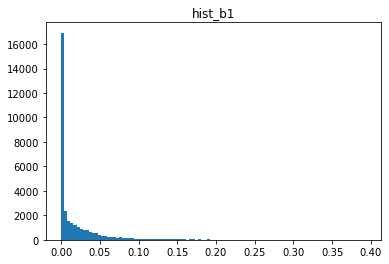

In [20]:
plt.title("hist_b1")
plt.hist(oof_full["b1"], bins = 100)
plt.show()

In [21]:
#### creating the test file ####

test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [22]:
## Loading test submission files ##
sub_pub = pd.read_csv("../input/triple-stratified-kfold-with-tfrecords/submission.csv")
sub_b0 = pd.read_csv("../input/eff-net-b0-256x256/submission.csv")
sub_b1 = pd.read_csv("../input/fork-of-eff-net-b1-256x256/submission.csv")

In [23]:
sub_pub.shape , sub_b0.shape, sub_b1.shape

((10982, 2), (10982, 2), (10982, 2))

In [24]:
sub_pub.head()

,image_name,target
0,ISIC_0052060,0.027359
1,ISIC_0052349,0.025799
2,ISIC_0058510,0.025983
3,ISIC_0073313,0.024942
4,ISIC_0073502,0.032569


In [25]:
(sub_pub["image_name"] == sub_b0["image_name"]).sum() == len(test)

True

In [26]:
(sub_pub["image_name"] == sub_b1["image_name"]).sum() == len(test)

True

In [27]:
train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'b0', 'b1'],
      dtype='object')

In [28]:
test["pred"] = sub_pub["target"]
test["b0"] = sub_b0["target"]
test["b1"] = sub_b1["target"]

In [29]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,pred,b0,b1
0,ISIC_0052060,IP_3579794,male,70.0,NaN,0.027359,0.007234,0.000074
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.025799,0.001637,0.000242
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.025983,0.000631,0.000191
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.024942,0.001249,0.000255
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.032569,0.009063,0.003401


In [30]:
oof_full.head()

,image_name,target_x,pred,fold,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target_y,b0,b1
0,ISIC_2637011,0,0.018716,0,IP_7279968,male,45.0,head/neck,unknown,benign,0,0.002562,0.001035
1,ISIC_0076262,0,0.025360,0,IP_5075533,female,50.0,lower extremity,unknown,benign,0,0.000950,0.000017
2,ISIC_0074268,0,0.024038,0,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0.003208,0.000090
3,ISIC_0015719,0,0.020294,0,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0.000521,0.010929
4,ISIC_0082543,0,0.020425,0,IP_9463965,female,30.0,torso,unknown,benign,0,0.006413,0.000019


In [31]:
for col in ['sex', 'anatom_site_general_challenge']:
    encoder = preprocessing.LabelEncoder()
    oof_full[col].fillna('unknown', inplace = True)
    test[col].fillna('unknown', inplace = True)
    oof_full[col] = encoder.fit_transform(oof_full[col])
    test[col] = encoder.transform(test[col])

In [32]:
oof_full.head()

,image_name,target_x,pred,fold,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target_y,b0,b1
0,ISIC_2637011,0,0.018716,0,IP_7279968,1,45.0,0,unknown,benign,0,0.002562,0.001035
1,ISIC_0076262,0,0.025360,0,IP_5075533,0,50.0,1,unknown,benign,0,0.000950,0.000017
2,ISIC_0074268,0,0.024038,0,IP_8723313,0,55.0,6,unknown,benign,0,0.003208,0.000090
3,ISIC_0015719,0,0.020294,0,IP_3075186,0,45.0,6,unknown,benign,0,0.000521,0.010929
4,ISIC_0082543,0,0.020425,0,IP_9463965,0,30.0,4,unknown,benign,0,0.006413,0.000019


In [33]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,pred,b0,b1
0,ISIC_0052060,IP_3579794,1,70.0,5,0.027359,0.007234,0.000074
1,ISIC_0052349,IP_7782715,1,40.0,1,0.025799,0.001637,0.000242
2,ISIC_0058510,IP_7960270,0,55.0,4,0.025983,0.000631,0.000191
3,ISIC_0073313,IP_6375035,0,50.0,4,0.024942,0.001249,0.000255
4,ISIC_0073502,IP_0589375,0,45.0,1,0.032569,0.009063,0.003401


In [34]:
oof_full.fold.value_counts()

4    6555
2    6552
0    6536
1    6534
3    6515
Name: fold, dtype: int64

In [35]:
import gc

features = ['sex', 'age_approx','anatom_site_general_challenge', 'pred', 'b0', 'b1']

check = oof_full[oof_full["fold"] == 0][features]
print(check.shape)
del check
gc.collect()

check = oof_full[oof_full["fold"] != 0][features]
print(check.shape)
del check
gc.collect()

(6536, 6)
(26156, 6)


0

In [36]:
params= {
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.9,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 31,
    #'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
    }

In [37]:
features = ['sex', 'age_approx','anatom_site_general_challenge', 'pred', 'b0', 'b1']

X = oof_full[features]
y = oof_full["target_x"]
X_test = test[features]
y_pred_lgb = np.zeros(len(X_test))



oof = np.zeros(len(oof_full))
fold_n = 4
cv = fold_n


kf = GroupKFold(n_splits = fold_n)
#folds = StratifiedKFold(n_splits=fold_n, random_state=2020, shuffle=True)

for fold_n, (train_index, valid_index) in enumerate(kf.split(oof_full, groups = oof_full['patient_id'])):
#for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_boost_round=100000,
                valid_sets = [train_data, valid_data],
                verbose_eval=100,
                early_stopping_rounds = 300)
    
    a = lgb_model.predict(X.iloc[valid_index][features], num_iteration=lgb_model.best_iteration)
    oof[valid_index] = a
    print("CV score for this fold is: {:<8.5f}".format(roc_auc_score(y_valid, a)))
    print(y_valid.sum())
    print("temporary CV score now: {:<8.5f}".format(roc_auc_score(y, oof)))
    
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/cv

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

Fold 0 started at Mon Jul 27 11:52:47 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.943766	valid_1's auc: 0.909385
[200]	training's auc: 0.945817	valid_1's auc: 0.909826
[300]	training's auc: 0.948238	valid_1's auc: 0.907813
[400]	training's auc: 0.94978	valid_1's auc: 0.907854
Early stopping, best iteration is:
[160]	training's auc: 0.944961	valid_1's auc: 0.910304
CV score for this fold is: 0.91030 
142
temporary CV score now: 0.52223 
Fold 1 started at Mon Jul 27 11:52:49 2020
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.943489	valid_1's auc: 0.893622
[200]	training's auc: 0.946078	valid_1's auc: 0.896648
[300]	training's auc: 0.949178	valid_1's auc: 0.900858
[400]	training's auc: 0.9506	valid_1's auc: 0.903343
[500]	training's auc: 0.951235	valid_1's auc: 0.903232
[600]	training's auc: 0.952685	valid_1's auc: 0.902273
[700]	training's auc: 0.95421	valid_1's auc: 0.901777
Early stopping, best itera

In [38]:
print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))  #### what the fuck ####

CV score: 0.81595 


In [39]:
y.value_counts()

0    32111
1      581
Name: target_x, dtype: int64

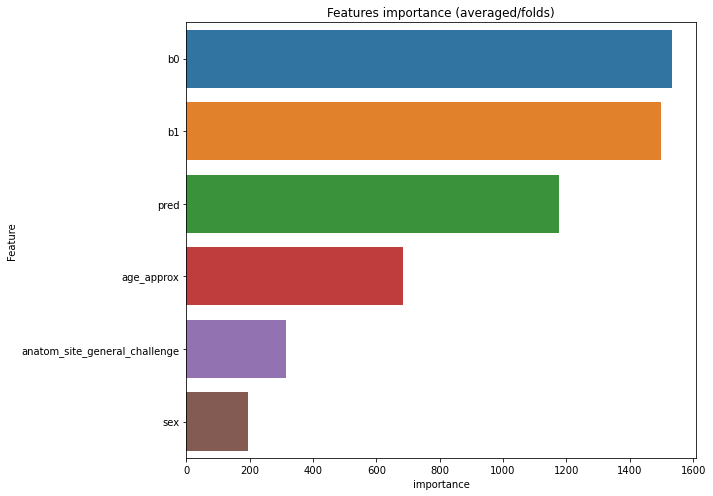

In [40]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,7))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [41]:
feature_importance_df

,Feature,importance,fold
0,sex,196,4
1,age_approx,683,4
2,anatom_site_general_challenge,315,4
3,pred,1176,4
4,b0,1533,4
5,b1,1497,4


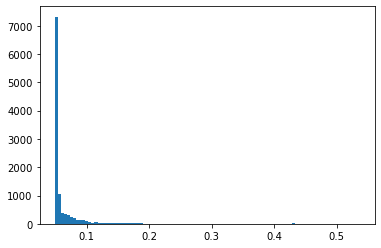

In [42]:
plt.hist(y_pred_lgb, bins = 100)
plt.show()

In [43]:
np.corrcoef(oof , pub_oof["pred"])

array([[1.        , 0.68738455],
       [0.68738455, 1.        ]])

In [44]:
np.corrcoef(y_pred_lgb , pub_sub["target"])

array([[1.        , 0.95442606],
       [0.95442606, 1.        ]])